<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">


#**Análise Exploratória de Dados de Logística**

## 1\. Contexto

A **Loggi** enfrenta desafios operacionais devido à variação na densidade demográfica em três regiões do Distrito Federal. Este projeto aborda se a quantidade de HUBs é suficiente e se a distribuição de entregas entre eles está otimizada, visando aprimorar a eficiência logística e adaptabilidade da empresa.


## 2\. Pacotes e bibliotecas

In [38]:
#Configurando e importando todas as bibliotecas necessárias para o projeto.



import json

import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

#Instalando pacotes necessários
!pip install haversine
!pip3 install geopandas

!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
!wget -q "https://raw.githubusercontent.com/AnthonyCavalcante/Estudos_python/main/EBAC/Web-scraping/support_project.py" -O support_project.py

!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 3\. Exploração de dados

###3.1 - Coleta de Dados

In [15]:
# Extraindo as informações de entregas de um arquivo JSON e carregando em um dicionário Python.
with open('deliveries.json', mode='r', encoding='utf8') as file:
  dados = json.load(file)

###3.2 - Wrangling

In [6]:

#Organizando a estrutura de dados
dados_df = pd.DataFrame(dados)

# Normalizando a coluna origin
dados_origin_df = pd.json_normalize(dados_df["origin"])

#Realizando a fusão dos DataFrames por meio do método merge do Pandas, utilizando um inner join através dos índices.
dados_df = pd.merge(left=dados_df, right=dados_origin_df, how='inner', left_index=True, right_index=True)
dados_df = dados_df.drop("origin", axis=1)

#Selecionando e renomeando as colunas recém-adicionadas no DataFrame.
dados_df = dados_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
dados_df.rename(columns={"lng": "initial_lng", "lat": "initial_lat"}, inplace=True)

# Aplicando o método "explode"
dados_exploded_df = dados_df[["deliveries"]].explode("deliveries")

#Criando um novo DataFrame com uma coluna para cada informação e, em seguida, concatenando-os em um único DataFrame.
dados_normalized_df = pd.concat([
  pd.DataFrame(dados_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(dados_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(dados_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

#retornando coluna para o dataframe original
dados_df = dados_df.drop("deliveries", axis=1)
dados_df = pd.merge(left=dados_df, right=dados_normalized_df, how='right', left_index=True, right_index=True)
dados_df.reset_index(inplace=True, drop=True)

In [7]:
#Exibindo o DataFrame dados_df.
dados_df.head()

,name,region,initial_lng,initial_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


###3.3 - Exploração do Schema

In [8]:
dados_df.head(n=5)

,name,region,initial_lng,initial_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


 - Colunas e seus respectivos tipos de dados.

In [9]:
dados_df.dtypes

name                 object
region               object
initial_lng         float64
initial_lat         float64
vehicle_capacity      int64
delivery_size         int64
delivery_lng        float64
delivery_lat        float64
dtype: object

 - Atributos **numéricos**.

In [10]:
dados_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


###3.5 Dados Faltantes

Dados faltantes podem ser:

 - Vazios (`""`);
 - Nulos (`None`);
 - Não disponíveis ou aplicaveis (`na`, `NA`, etc.);
 - Não numérico (`nan`, `NaN`, `NAN`, etc).

In [11]:
dados_df.isna().any()

name                False
region              False
initial_lng         False
initial_lat         False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

In [ ]:
dados_df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708
hub_city,636149,3,Brasília,304708
hub_suburb,636149,3,Asa Sul,304708
delivery_city,634447,38,Brasília,148983
delivery_suburb,476264,167,Brasília,53795


Existem 199 identificadores de nomes (names id) em que o "cvrp-1-df-87" é o mais frequentemente encontrado. Além disso, identificamos 3 Hubs de distribuição, sendo que o "df-1" é o que possui a maior frequência, indicando ser o hub com o volume mais significativo de entregas.

In [34]:
dados_df.select_dtypes('int').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


Observação 1: É notável que os dados na coluna "vehicle_capacity" não exibem variação, mantendo-se constantes em todos os valores, que são iguais a "180".

Observação 2: Os valores na coluna "delivery_size" indicam uma variação moderada nos volumes, com uma média de 5.5121 e uma mediana de 6.0000. O desvio padrão de 2.8746, juntamente com a baixa amplitude, sugere variações relativamente

## 4\. Manipulação

###4.1 - Enriquecimento###

- **Geocodificação reversa do hub**
  

A **geocodificação** é o procedimento que converte uma localização descrita por texto (endereço, nome do local, etc.) em suas coordenadas geográficas correspondentes (latitude e longitude). Por outro lado, a **geocodificação reversa** realiza o processo inverso, convertendo coordenadas geográficas de um local em suas respectivas descrições textuais.

In [12]:
hub_df = dados_df[["region", "initial_lng", "initial_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,initial_lng,initial_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


Vamos utilizar um serviço de geocodificação chamado [Nominatim] através do pacote Python `geopy` para fazer a operação reversa e enriquecer o nosso DataFrame principal.

In [14]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 46410411,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright",
  "osm_type": "way",
  "osm_id": 240210480,
  "lat": "-15.656916027876347",
  "lon": "-47.80264463632131",
  "class": "highway",
  "type": "secondary",
  "place_rank": 26,
  "importance": 0.10000999999999993,
  "addresstype": "road",
  "name": "Rua 7",
  "display_name": "Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "stat

In [16]:
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [18]:
hub_df["coordinates"] = hub_df["initial_lat"].astype(str)  + ", " + hub_df["initial_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,initial_lng,initial_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [19]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.city,address.shop,address.house_number
0,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172757199022,-47.893723539491205,highway,residential,26,0.10001,...,Distrito Federal,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,SQS 303,Brasília,NaN,NaN
2,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.00001,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [20]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-20-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-20-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-20-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


O DataFrame `hub_geodata_df` com as informações de **cidade** e **bairro** é então combinado ao DataFrame principal `dados_df`, enriquecendo assim o dado.

In [21]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


In [22]:
dados_df = pd.merge(left=dados_df, right=hub_df, how="inner", on="region")
dados_df = dados_df[["name", "region", "initial_lng", "initial_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
dados_df.head()

,name,region,initial_lng,initial_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


**Geocodificação da entrega dos pedidos**

> **Atenção:** Como não iremos instalar programas externos, nós vamos providenciar estes dados para você através deste [link](https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv).

In [27]:
dados_geodata_df = pd.read_csv("deliveries-geodata.csv")
dados_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [28]:
dados_df = pd.merge(left=dados_df, right=dados_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
dados_df.head()

,name,region,initial_lng,initial_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Após a fusão dos DataFrames utilizando as colunas de "delivery_city" e "delivery_suburb", observamos que agora o DataFrame dados_df possui informações adicionais sobre a cidade e o bairro de entrega. Isso abre oportunidades para análises mais granulares, possibilitando a avaliação das características das entregas em contextos urbanos específicos.

#5 - Visualização

**Mapa do Distrito Federal**

In [39]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]


,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [41]:
# Criando o DataFrame geo_hub_df através do DataFrame dados_df
hub_df = dados_df[['region', 'initial_lat', 'initial_lng']].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["initial_lng"], hub_df["initial_lat"]))
geo_dados_df = geopandas.GeoDataFrame(dados_df, geometry= geopandas.points_from_xy(dados_df['delivery_lng'], dados_df['delivery_lat']))

In [42]:
#Mapa de Entrega
geo_dados_df = geopandas.GeoDataFrame(dados_df, geometry=geopandas.points_from_xy(dados_df["delivery_lng"], dados_df["delivery_lat"]))
geo_dados_df.head()

,name,region,initial_lng,initial_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


**Viualização do Gráfico**

<ipython-input-43-750344267fa3>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


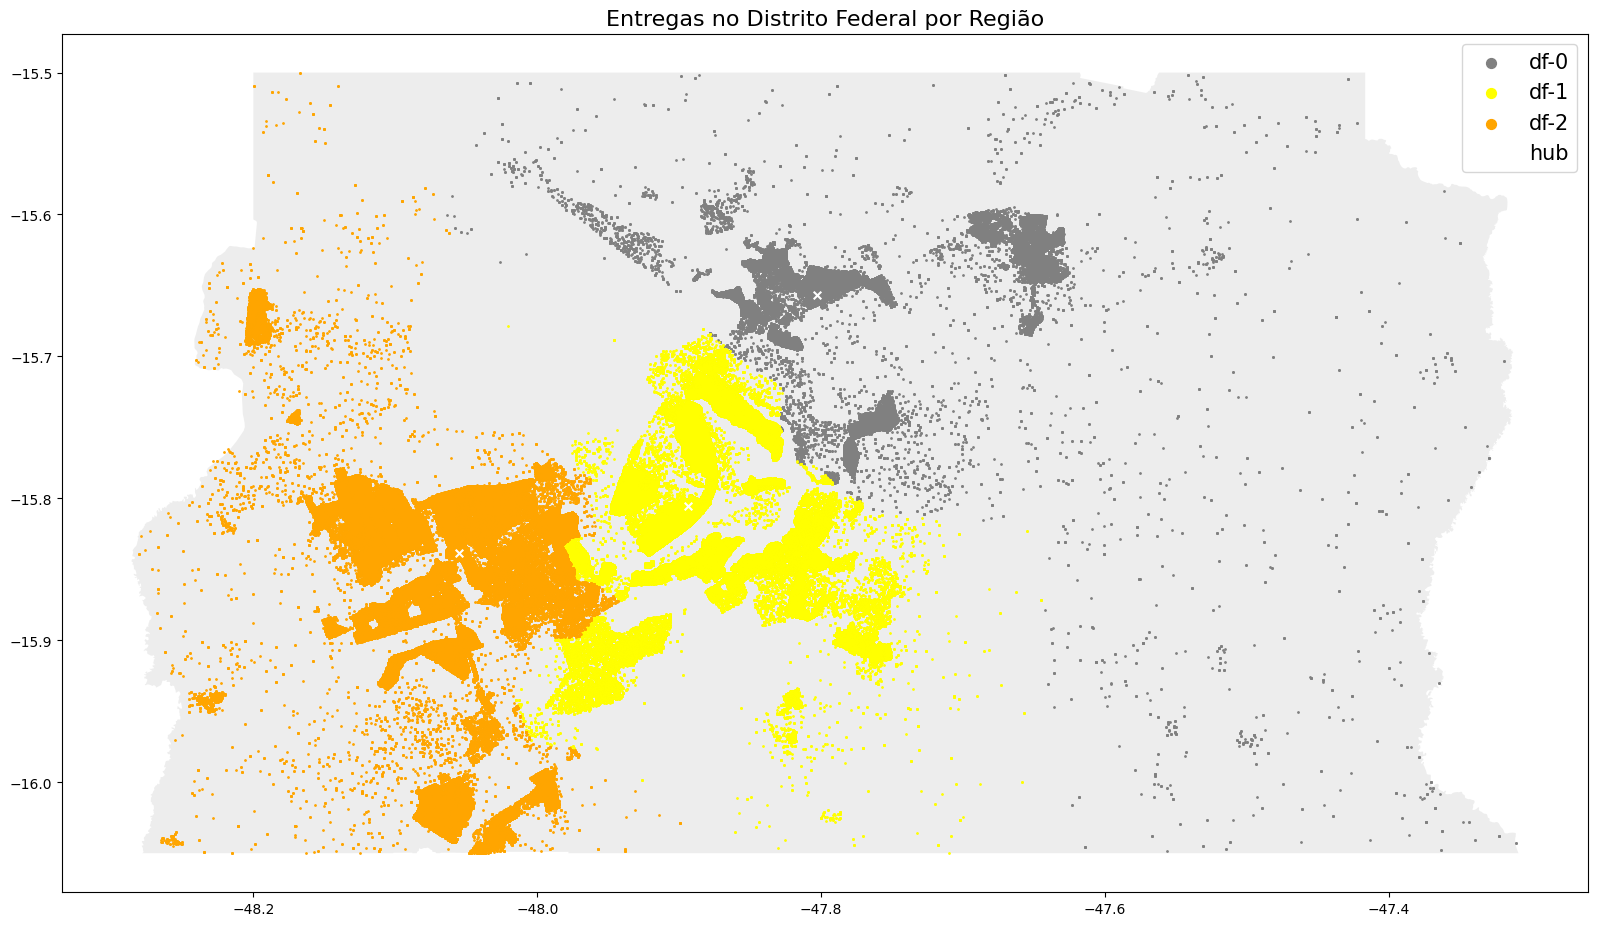

In [43]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_dados_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="gray", label="df-0")
geo_dados_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="yellow", label="df-1")
geo_dados_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="orange", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="white", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

* **Insights:**
- Este gráfico oferece uma visão geoespacial das entregas no Distrito Federal, segmentadas por região. Observamos que as entregas da região "df-0" são representadas em cinza, "df-1" em amarelo e "df-2" em laranja. Os hubs são identificados por marcadores "x" brancos.

- A distribuição espacial das entregas nas diferentes regiões, indicando variações significativas nas demandas logísticas em cada área. A presença dos hubs também destaca os pontos de origem centralizados para as entregas.

- Essa representação visual fornece uma compreensão rápida e intuitiva da distribuição das atividades logísticas no Distrito Federal, facilitando a identificação de padrões e pontos de concentração.

**Gráfico de entregas por região**

In [44]:
#Agregação
data = pd.DataFrame(dados_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-46-ed1fd63a89db>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="dark")


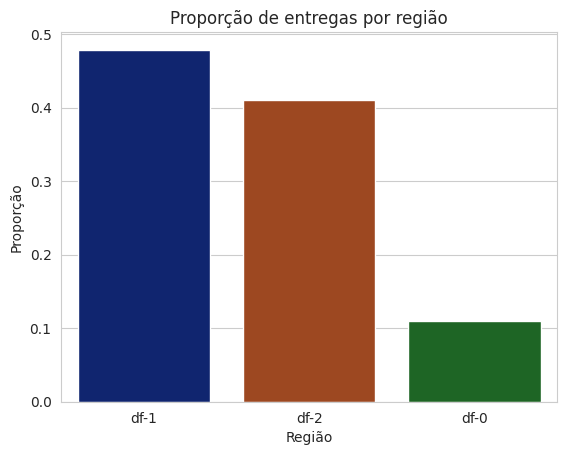

In [46]:
#Visualização
with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", ci=None, palette="dark")
  grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

* **Insights:**

 - Neste gráfico de barras, que destaca a proporção de entregas por região no Distrito Federal, podemos observar visualmente as diferenças relativas entre as regiões "df-0", "df-1" e "df-2". A paleta de cores escura ajuda a distinguir claramente cada região.

 - É possível identificar quais regiões contribuem mais significativamente para o total de entregas. A barra mais alta indica a região com a maior proporção, enquanto as barras mais baixas indicam regiões com menor participação no volume total de entregas.
 - Essa representação gráfica fornece uma visão resumida e comparativa da distribuição de entregas entre as diferentes regiões, permitindo uma análise rápida das proporções relativas.

#6 - Storytelling

1 - **Uniformidade nas Capacidades dos Veículos:**
Ao analisar os dados, observamos que a coluna "vehicle_capacity" revela uniformidade, indicando que todos os veículos utilizados nas entregas possuem capacidade constante de "180". Essa consistência pode facilitar a gestão da frota, garantindo padronização e eficiência operacional.

2 - **Variação Moderada nos Tamanhos de Entregas:**
A coluna "delivery_size" revela uma variação moderada nos tamanhos de entregas, com uma média de 5.5121 e uma mediana de 6.0000. O desvio padrão de 2.8746, juntamente com a baixa amplitude, sugere variações relativamente moderadas nos volumes, facilitando o planejamento logístico.

3 - **GeoVisualização dos Hubs e Entregas:**
Utilizando GeoPandas, mapeamos as coordenadas dos hubs e entregas no Distrito Federal. Essa visualização geoespacial destaca a distribuição heterogênea das entregas por região, permitindo identificar padrões e concentrar esforços logísticos em áreas estratégicas.

4 - **Distribuição Espacial das Entregas por Região:**
No gráfico geoespacial, notamos que as entregas são segmentadas por região ("df-0", "df-1" e "df-2"). As diferentes cores indicam as regiões, e os hubs são identificados como marcadores "x". Essa representação facilita a identificação de padrões e concentrações de atividades logísticas.

5 - **Proporção de Entregas por Região:**
O gráfico de barras destaca a proporção de entregas em cada região. A barra mais alta indica a região com a maior contribuição para o total de entregas, proporcionando insights sobre a distribuição relativa das atividades logísticas no Distrito Federal.

6 - **Conclusão:**
Estes insights fornecem uma compreensão abrangente dos padrões logísticos no Distrito Federal. A uniformidade nas capacidades dos veículos, a variação moderada nos tamanhos de entregas e a distribuição espacial destacam áreas de eficiência e oportunidades de otimização. Utilizando essas informações, a Loggi pode aprimorar suas estratégias logísticas para garantir uma entrega eficiente e adaptada às características específicas de cada região atendida.